# Rossmann Store Sales Forecast
Rossmann 是德国最大的日化品连锁超市，遍布欧洲多个国家

In [1]:
#导入需要的包
import numpy as np
import pandas as pd
from pandas import Series,DataFrame
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from time import time

%matplotlib inline

f:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# 读入数据

In [2]:
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")
df_store = pd.read_csv("data/store.csv")

df_train.head()
#train.describe()
#test.describe()
#store.describe()

f:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


# 观察分析数据

In [3]:
df_train.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday'],
      dtype='object')

* Store: 门店编号
* DayOfWeek:一周的第几天，如5，代表周五
* Date：  日期
* Sales:  销售额
* Customers:顾客数量
* Open:     开业状态，1代表开业，0代表关店
* Promo:    有无促销活动，1代表有促销，0代表无促销
* StateHoliday：是否是州假日，a=公共假日，b=复活节，c=圣诞节，0=不是州假日
* SchoolHoliday:是否是学校假日

In [4]:
#增加所在的月份、所在周数 和平均每个客户的花费
df_train['Month']=pd.to_datetime(df_train['Date']).dt.month
df_train['WeekOfYear']=pd.to_datetime(df_train['Date']).dt.weekofyear
df_train['SalesPerCustomer'] = df_train.Sales / df_train.Customers
df_train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Month,WeekOfYear,SalesPerCustomer
0,1,5,2015-07-31,5263,555,1,1,0,1,7,31,9.482883
1,2,5,2015-07-31,6064,625,1,1,0,1,7,31,9.702400
2,3,5,2015-07-31,8314,821,1,1,0,1,7,31,10.126675
3,4,5,2015-07-31,13995,1498,1,1,0,1,7,31,9.342457
4,5,5,2015-07-31,4822,559,1,1,0,1,7,31,8.626118


In [5]:
df_store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


* Store ：门店编号
* StoreType:门店类型,a，b，c，d
* Assortment: 描述分类级别：a =基本，b =额外，c =扩展
* CompetitionDistance:与最近竞争对手门店的距离
* CompetitionOpenSinceMonth:最近竞争对手开店的月份
* CompetitionOpenSinceYear: 最近竞争对手开店年份
* Promo2:有无连续促销活动，0代表没有，1代表有
* Promo2SinceWeek:描述商店开始参与连续促销的日历周
* Promo2SinceYear:描述商店开始参与连续促销的年份
* PromoInterval:描述Promo2启动的连续间隔，命名重新开始促销的月份。例如，“2月，5月，8月，11月”意味着每一轮在该商店的任何给定年份的2月，5月，8月和11月开始

In [6]:
df_test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


查看训练集中是否存Open状态为营业，但销售额为0的店

In [7]:
#看一下是否存在开店状态下，销售额为0的情况
df_train[(df_train.Open==1) & (df_train.Sales==0)].shape[0]
#df_train[df_train.Sales==0]
#df_train[df_train.Open==0]

54

结果显示有54家状态为开业，但销售额却是0。
下面看一下在关店状态下，是否存在销售额大于0的

In [8]:
df_train[(df_train.Open==0) & (df_train.Sales>0)].shape[0]

0

事实上是不存在关店状态下销售额大于0这样的情况

In [9]:
#查看训练集、测试集和store中数据缺失情况
display(df_train.isnull().sum(),df_test.isnull().sum(),df_store.isnull().sum())

Store                    0
DayOfWeek                0
Date                     0
Sales                    0
Customers                0
Open                     0
Promo                    0
StateHoliday             0
SchoolHoliday            0
Month                    0
WeekOfYear               0
SalesPerCustomer    172869
dtype: int64

Id                0
Store             0
DayOfWeek         0
Date              0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
dtype: int64

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [10]:
#看一下df_store数据集中CompetitionDistance为空的具体情况
df_store[pd.isnull(df_store.CompetitionDistance)]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


In [12]:
df_store[pd.isnull(df_store.CompetitionOpenSinceMonth)]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
11,12,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
12,13,d,a,310.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
15,16,a,c,3270.0,NaN,NaN,0,NaN,NaN,NaN
18,19,a,c,3240.0,NaN,NaN,1,22.0,2011.0,"Mar,Jun,Sept,Dec"
21,22,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"
25,26,d,a,2300.0,NaN,NaN,0,NaN,NaN,NaN
28,29,d,c,2170.0,NaN,NaN,0,NaN,NaN,NaN
31,32,a,a,2910.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
39,40,a,a,180.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
40,41,d,c,1180.0,NaN,NaN,1,31.0,2013.0,"Jan,Apr,Jul,Oct"


从上面数据来看，df_store 数据集中291、622和879 这三家店附近没有竞争对手，因此与竞争对手相关的指标(CompetitionOpenSinceMonth、CompetitionOpenSinceYear)也是空值，这是符合逻辑的，为了便于处理，后续的步骤中将会对着三家的缺失值进行补全。但是从另一方面来看CompetitionOpenSinceMonth（或CompetitionOpenSinceMonth）是空值的，竞争对手CompetitionDistance不一定为空

In [15]:
#df_store[df_store[df_store.Promo2==0 ]][['Promo2SinceWeek','Promo2SinceYear','PromoInterval']]
df_store[df_store.Promo2==0 ]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
5,6,a,a,310.0,12.0,2013.0,0,NaN,NaN,NaN
6,7,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN
7,8,a,a,7520.0,10.0,2014.0,0,NaN,NaN,NaN
8,9,a,c,2030.0,8.0,2000.0,0,NaN,NaN,NaN
9,10,a,a,3160.0,9.0,2009.0,0,NaN,NaN,NaN
15,16,a,c,3270.0,NaN,NaN,0,NaN,NaN,NaN
22,23,d,a,4060.0,8.0,2005.0,0,NaN,NaN,NaN


没有参加连续促销的这544家店，Promo2SinceWeek、Promo2SinceWeek和PromoInterval都为空值，这是符合正常逻辑的。

In [16]:
df_train.StateHoliday.unique()

array(['0', 'a', 'b', 'c', 0], dtype=object)

StateHoliday的取值中，存在字符"0"和数字0，其实这两个均所指是：不为州假日

In [1]:
df_train[(df_train.StateHoliday==0) | (df_train.StateHoliday=='0')].shape()

NameError: name 'df_train' is not defined

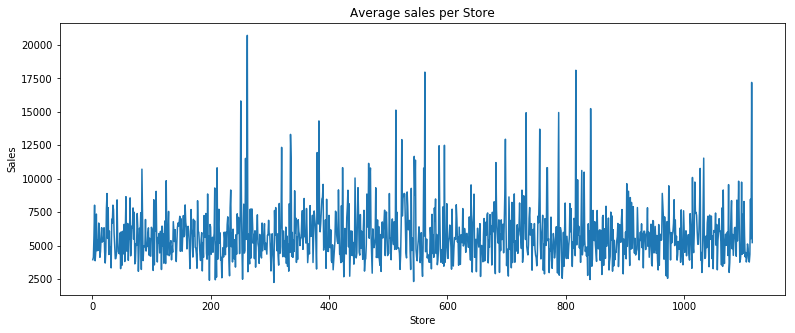

In [18]:
#df_train.groupby('Store')[['Sales']].mean().plot figsize=(15,5), marker='o')
#df_train.Sales.max()
#df_train
#查看各店平均销售额的分布图
df_train.groupby(['Store'])['Sales'].mean().plot(figsize=(13,5))
plt.title('Average sales per Store')
plt.ylabel('Sales');


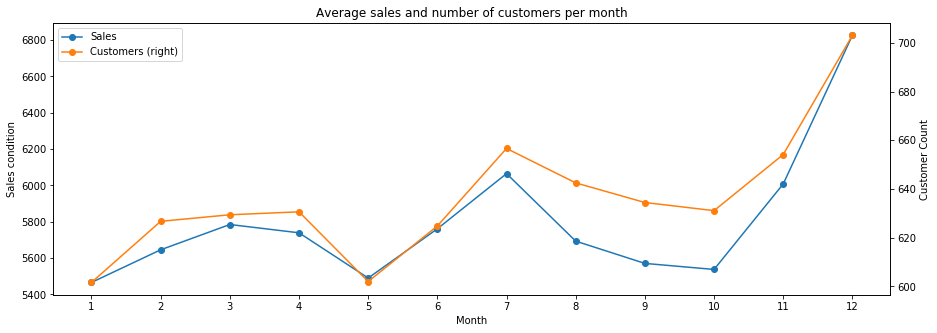

In [19]:
#销售额和客户数平均每月分布情况
ax = df_train.groupby('Month')[['Sales', 'Customers']].mean().plot(secondary_y=['Customers'], figsize=(15,5), marker='o')
ax.set_ylabel('Sales condition')
ax.right_ax.set_ylabel('Customer Count')
ax.set_xticks(range(1,13))
plt.title('Average sales and number of customers per month');

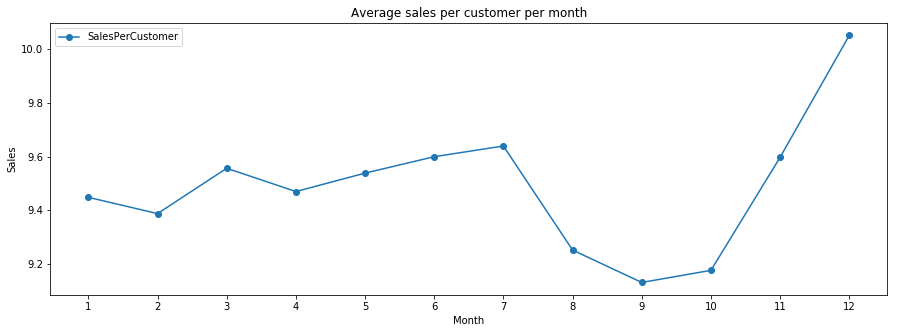

In [20]:
# 平均每个客户每月对销售额贡献情况
ax = df_train.groupby('Month')[['SalesPerCustomer']].mean().plot(figsize=(15,5), marker='o')
ax.set_ylabel('Sales')
ax.set_xticks(range(1,13))
plt.title('Average sales per customer per month');

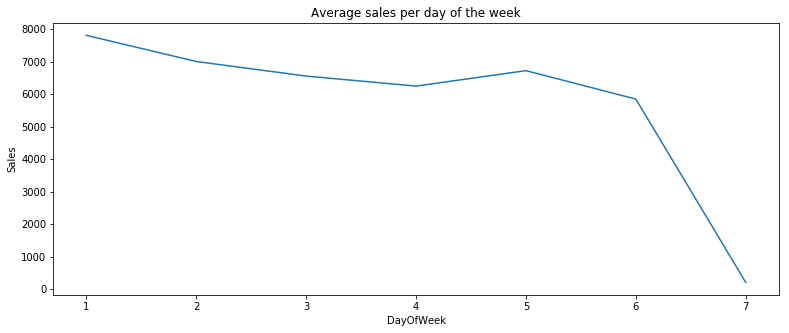

In [21]:
#一周平均每天的销售额趋势图
df_train.groupby(['DayOfWeek'])['Sales'].mean().plot(figsize=(13,5))
plt.title('Average sales per day of the week')
plt.ylabel('Sales');

从上图可以看出周一整体销售情况较好，而周日的情况则相反

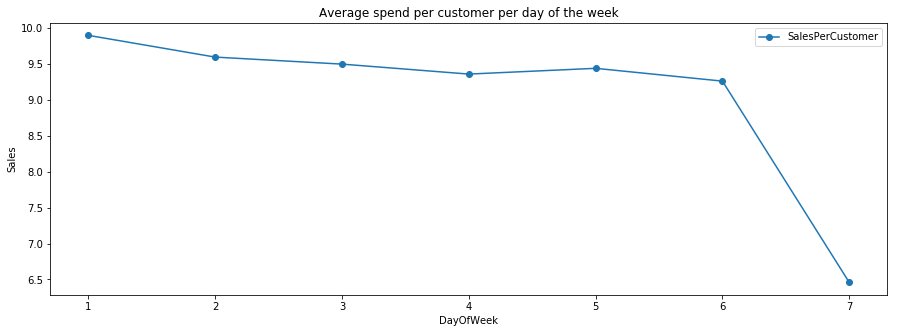

In [22]:
ax = df_train.groupby('DayOfWeek')[['SalesPerCustomer']].mean().plot(figsize=(15,5), marker='o')
ax.set_ylabel('Sales')
plt.title('Average spend per customer per day of the week');


f:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
f:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


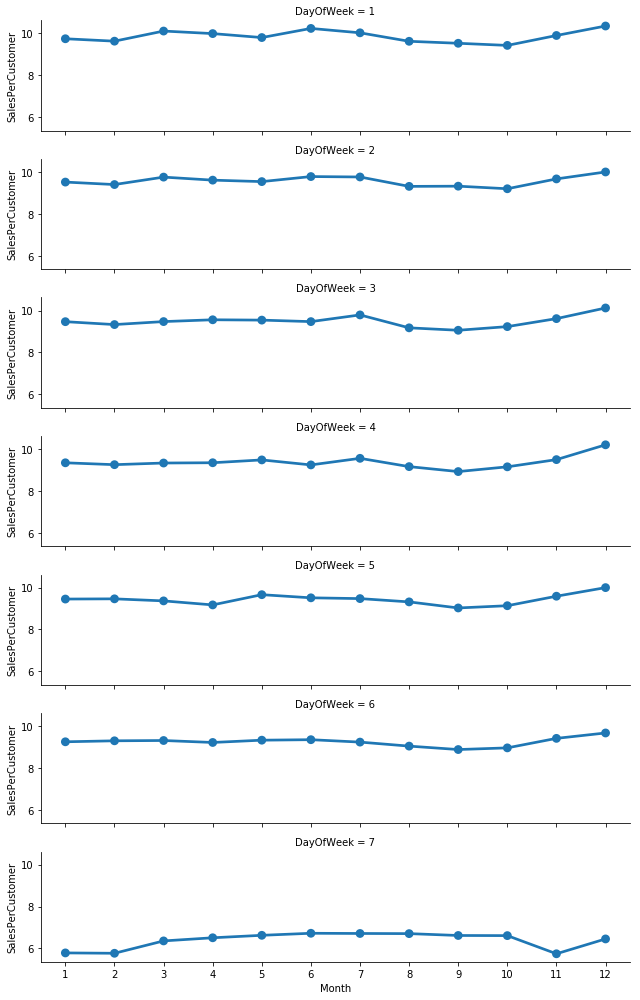

In [23]:
tmp = df_train.groupby(['Month', 'DayOfWeek'])['SalesPerCustomer'].mean().reset_index()
sns.factorplot(data = tmp, x = 'Month', y = "SalesPerCustomer", row = 'DayOfWeek',
              size=2, aspect=4.5);

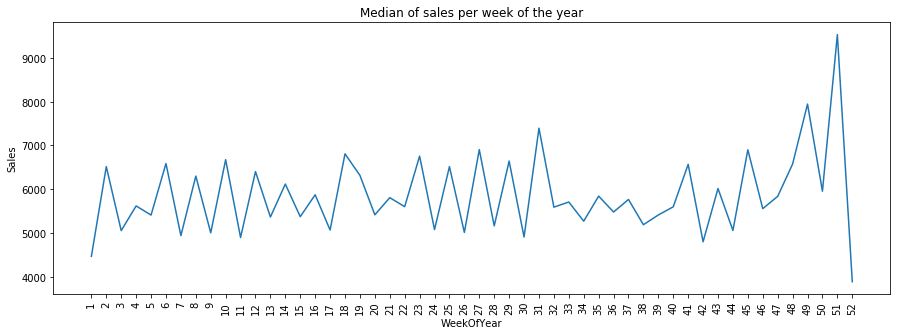

In [24]:
df_train.groupby('WeekOfYear')['Sales'].median().plot(figsize=(15,5), xticks=np.arange(1,53), rot=90)
plt.title('Median of sales per week of the year')
plt.ylabel('Sales');#不同年每个月份平均销售情况


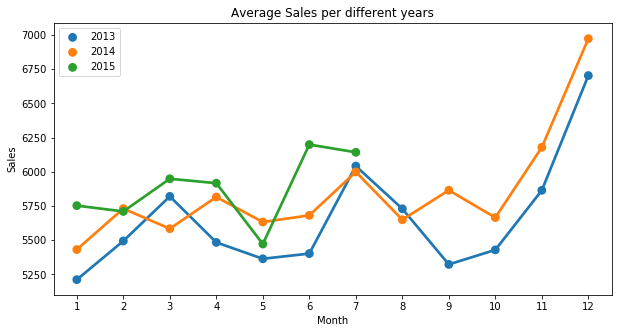

In [31]:
#不同年每个月份平均销售情况
df_train['year']=pd.to_datetime(df_train['Date']).dt.year
df5=df_train.Sales.groupby([df_train.year,df_train.Month]).mean().reset_index()
fig=plt.figure(figsize=(10,5))
ax=fig.add_subplot(1,1,1)
sns.pointplot(x='Month',y='Sales',hue='year',data=df5,ax=ax)
ax.set_title('Average Sales per different years')
plt.legend(loc='best')

小结：从上面几张图中可以看出有以下情况：
- 从一周来看，周一整体销售情况较好，而周日的情况则相反
- 从一年来看，12月份的销售情况较好，而1月份的情况相反

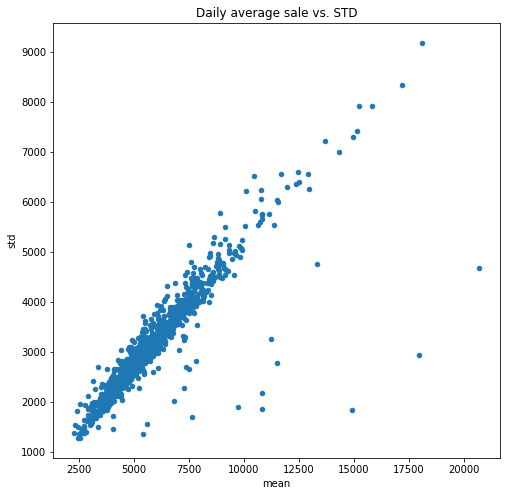

In [32]:
tmp = df_train.groupby(['Store'])['Sales'].agg(['mean', 'std']).sort_values('mean')
tmp.plot.scatter('mean', 'std', figsize=(8,8))
plt.title('Daily average sale vs. STD');

f:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


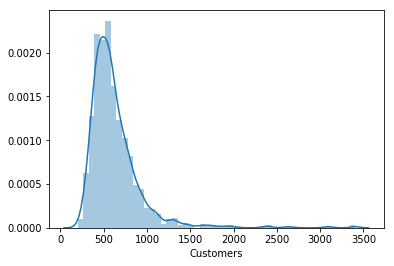

In [33]:
sns.distplot(df_train.groupby(['Store'])['Customers'].mean())

No handles with labels found to put in legend.


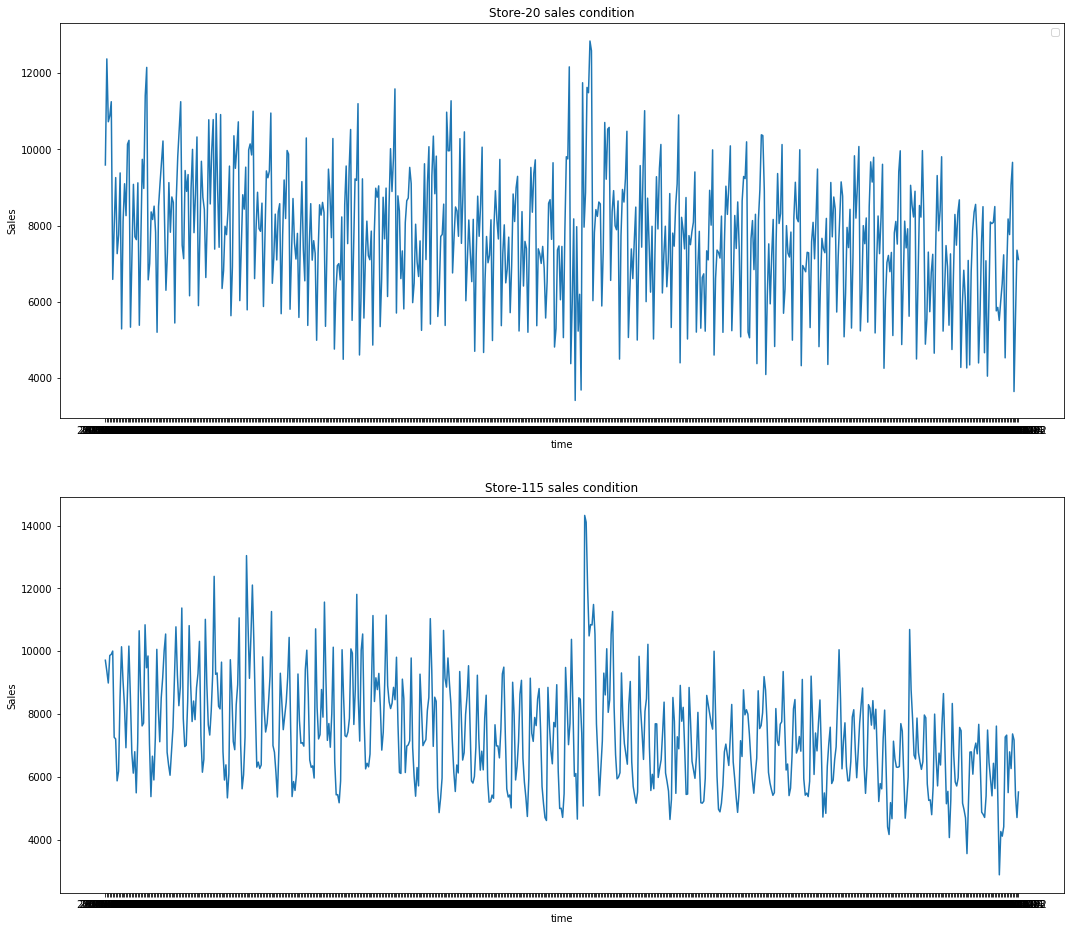

In [34]:
#随机选取20和115号店，关注整体的销售情况
store_20 = df_train.loc[(df_train["Store"]==20)&(df_train['Sales']>0), ['Date',"Sales"]]
store_115 = df_train.loc[(df_train["Store"]==115)&(df_train['Sales']>0), ['Date',"Sales"]]
f = plt.figure(figsize=(18,16))

ax1 = f.add_subplot(211)
ax1.legend()
ax1.plot(store_20['Date'], store_20['Sales'], '-')
ax1.set_xlabel('time')
ax1.set_ylabel('Sales')
ax1.set_title('Store-20 sales condition')

ax2 = f.add_subplot(212)
ax2.plot(store_115['Date'], store_115['Sales'], '-')
ax2.set_xlabel('time')
ax2.set_ylabel('Sales')
ax2.set_title('Store-115 sales condition')
plt.show()

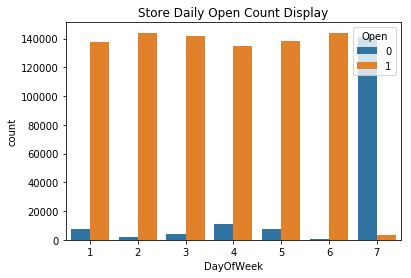

In [37]:
#训练集中商店一周的营业和关闭的整体情况
sns.countplot(x = 'DayOfWeek', hue = 'Open', data = df_train)
plt.title('Store Daily Open Count Display')
plt.show()

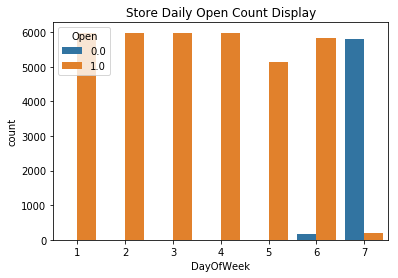

In [38]:
#测试集中商店一周的营业和关闭的整体情况
sns.countplot(x = 'DayOfWeek', hue = 'Open', data = df_test)
plt.title('Store Daily Open Count Display')
plt.show()

In [39]:
#临时连接train和store数据集
tmp_train_store = pd.merge(df_train, df_store, on='Store')

f:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
No handles with labels found to put in legend.


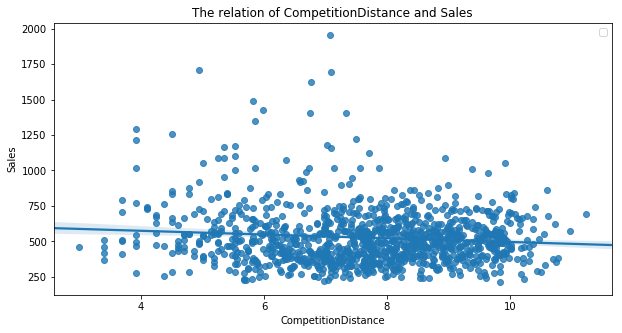

In [40]:
tmp_train=tmp_train_store.groupby('Store')['CompetitionDistance','Sales'].agg({'CompetitionDistance':'mean','Sales':'sum'})#每个店销售总额
tmp_train['CompetitionDistance']=tmp_train['CompetitionDistance'].map(lambda x:np.log(x))#对距离取log，收缩分布
tmp_train['Sales']=tmp_train['Sales'].map(lambda x:x/10000)#销售额以万元为单位
fig=plt.figure(figsize=(10,5))
ax=fig.add_subplot(1,1,1)
sns.regplot(x='CompetitionDistance',y='Sales',data=tmp_train,ax=ax)
ax.set_title('The relation of CompetitionDistance and Sales')
plt.legend(loc='best')

上图可以简单看出，与竞争对手的店处在一定距离，销售额聚集在一个区域范围

f:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


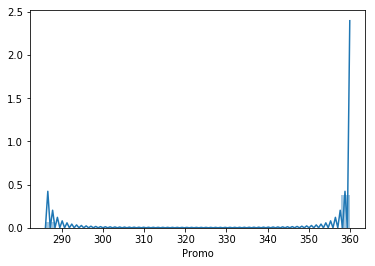

In [41]:
#店铺促销次数比例分布
tmp_train=tmp_train_store.groupby('Store')['Promo'].sum()
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
sns.distplot(tmp_train,ax=ax)

[Text(0.5,1,'Store Promo counts display')]

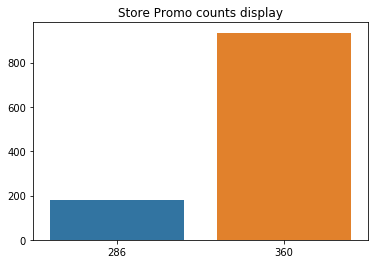

In [42]:
tmp_train_1=tmp_train.value_counts()
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
sns.barplot(tmp_train_1.index,tmp_train_1.values,ax=ax)
ax.set(**{'title':'Store Promo counts display'})


[Text(0.5,1,'Promo and No Promo Display')]

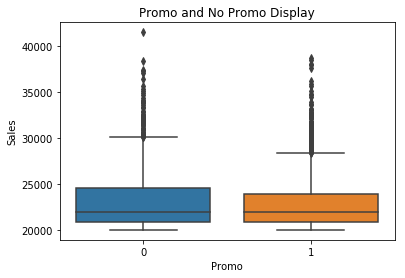

In [48]:
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
sns.boxplot(y='Sales',x='Promo',data=tmp_train_store[tmp_train_store.Sales>20000],ax=ax)
ax.set(**{'title':'Promo and No Promo Display'})

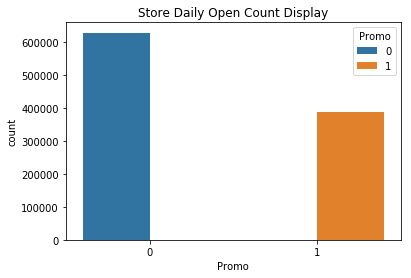

In [49]:
#测试集中商店一周的营业和关闭的整体情况
sns.countplot(x = 'Promo', hue = 'Promo', data = tmp_train_store)
plt.title('Store Daily Open Count Display')
plt.show()

# 接下来对缺失值进行补全
1、首先是对store的各缺失值进行补全操作

In [50]:
df_store['CompetitionDistance'].fillna(df_store['CompetitionDistance'].median(), inplace = True)

In [39]:
df_store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            0
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [51]:
df_train.head().append(df_train.tail())

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Month,WeekOfYear,SalesPerCustomer,year
0,1,5,2015-07-31,5263,555,1,1,0,1,7,31,9.482883,2015
1,2,5,2015-07-31,6064,625,1,1,0,1,7,31,9.702400,2015
2,3,5,2015-07-31,8314,821,1,1,0,1,7,31,10.126675,2015
3,4,5,2015-07-31,13995,1498,1,1,0,1,7,31,9.342457,2015
4,5,5,2015-07-31,4822,559,1,1,0,1,7,31,8.626118,2015
1017204,1111,2,2013-01-01,0,0,0,0,a,1,1,1,NaN,2013
1017205,1112,2,2013-01-01,0,0,0,0,a,1,1,1,NaN,2013
1017206,1113,2,2013-01-01,0,0,0,0,a,1,1,1,NaN,2013
1017207,1114,2,2013-01-01,0,0,0,0,a,1,1,1,NaN,2013
1017208,1115,2,2013-01-01,0,0,0,0,a,1,1,1,NaN,2013


In [12]:
#查看是否Promo2系列的缺失是否是因为没有参加促销
NoPW = store[pd.isnull(store.Promo2SinceWeek)]
NoPW[NoPW.Promo2 != 0].shape

(0, 10)

In [53]:
#缺失值处理
#我们将test中的open数据补为1，即营业状态
df_test.fillna(1, inplace=True)
#store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(), inplace = True)
#store['CompetitionOpenScinceYear'].fillna(store['CompetitionDistance'].median(), inplace = True)
#store['CompetitionOPenScinceMonth'].fillna(store['CompetitionDistance'].median(), inplace = True)


In [54]:
#store中的缺失数据大多与竞争对手和促销有关，在实验中我们发现竞争对手信息的中值填充效果并不好，所以这里统一采用0填充
df_store.fillna(0, inplace=True)

In [56]:
#查看是否还存在缺失值
display(df_train.isnull().sum(),df_test.isnull().sum(),df_store.isnull().sum())

Store                    0
DayOfWeek                0
Date                     0
Sales                    0
Customers                0
Open                     0
Promo                    0
StateHoliday             0
SchoolHoliday            0
Month                    0
WeekOfYear               0
SalesPerCustomer    172869
year                     0
dtype: int64

Id               0
Store            0
DayOfWeek        0
Date             0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

In [58]:
#合并store信息
train = pd.merge(df_train, df_store, on='Store')
test = pd.merge(df_test, df_store, on='Store')

In [59]:
#留出最近的6周数据作为hold_out数据集进行测试
train = train.sort_values(['Date'],ascending = False)
ho_test = train[:6*7*1115]
ho_train = train[6*7*1115:]

In [60]:
#因为销售额为0的记录不计入评分，所以只采用店铺为开，且销售额大于0的数据进行训练
ho_test = ho_test[ho_test["Open"] != 0]
ho_test = ho_test[ho_test["Sales"] > 0]
ho_train = ho_train[ho_train["Open"] != 0]
ho_train = ho_train[ho_train["Sales"] > 0]


In [61]:
#特征处理与转化，定义特征处理函数
def features_create(data):
    
    #将存在其他字符表示分类的特征转化为数字
    mappings = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
    data.StoreType.replace(mappings, inplace=True)
    data.Assortment.replace(mappings, inplace=True)
    data.StateHoliday.replace(mappings, inplace=True)
    
    #将时间特征进行拆分和转化，并加入'WeekOfYear'特征
    data['Year'] = data.Date.dt.year
    data['Month'] = data.Date.dt.month
    data['Day'] = data.Date.dt.day
    data['DayOfWeek'] = data.Date.dt.dayofweek
    data['WeekOfYear'] = data.Date.dt.weekofyear
    
    
    #新增'CompetitionOpen'和'PromoOpen'特征,计算某天某店铺的竞争对手已营业时间和店铺已促销时间，用月为单位表示
    data['CompetitionOpen'] = 12 * (data.Year - data.CompetitionOpenSinceYear) +  (data.Month - data.CompetitionOpenSinceMonth)
    data['PromoOpen'] = 12 * (data.Year - data.Promo2SinceYear) +  (data.WeekOfYear - data.Promo2SinceWeek) / 4.0
    data['CompetitionOpen'] = data.CompetitionOpen.apply(lambda x: x if x > 0 else 0)        
    data['PromoOpen'] = data.PromoOpen.apply(lambda x: x if x > 0 else 0)
    
    
    #将'PromoInterval'特征转化为'IsPromoMonth'特征,表示某天某店铺是否处于促销月，1表示是，0表示否
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    data['monthStr'] = data.Month.map(month2str)
    data.loc[data.PromoInterval == 0, 'PromoInterval'] = ''
    data['IsPromoMonth'] = 0
    for interval in data.PromoInterval.unique():
        if interval != '':
            for month in interval.split(','):
                data.loc[(data.monthStr == month) & (data.PromoInterval == interval), 'IsPromoMonth'] = 1
 
    return data


In [62]:
#对训练，保留以及测试数据集进行特征转化
features_create(ho_train)
features_create(ho_test)
features_create(test)
print('Features creation finished')

AttributeError: Can only use .dt accessor with datetimelike values

In [63]:
#删掉训练和保留数据集中不需要的特征
ho_train.drop(['Date','Customers','Open','PromoInterval','Month'],axis=1,inplace =True)
ho_test.drop(['Date','Customers','Open','PromoInterval','Month'],axis=1,inplace =True)


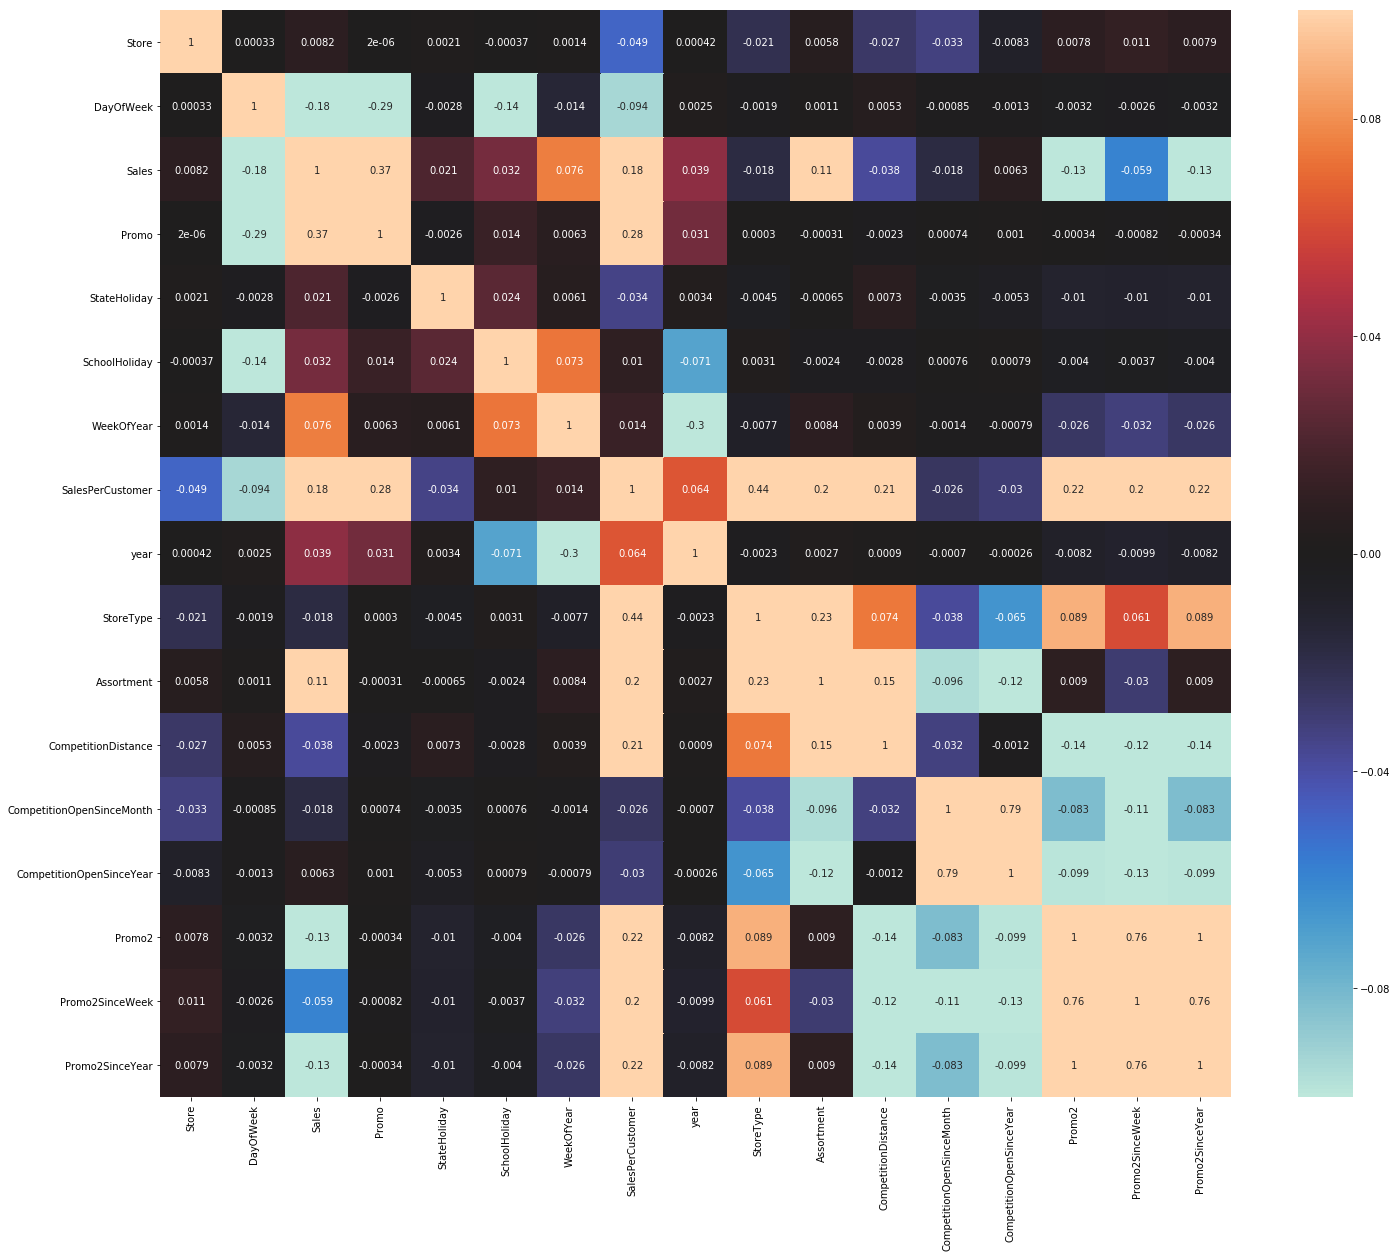

In [64]:
#分析训练数据集中特征相关性以及特征与'Sales'标签相关性
plt.subplots(figsize=(24,20))
sns.heatmap(ho_train.corr(),annot=True, vmin=-0.1, vmax=0.1,center=0)

In [65]:
#拆分特征与标签，并将标签取对数处理
ho_xtrain = ho_train.drop(['Sales'],axis=1 )
ho_ytrain = np.log1p(ho_train.Sales)
ho_xtest = ho_test.drop(['Sales'],axis=1 )
ho_ytest = np.log1p(ho_test.Sales)


In [69]:
#删掉测试集中对应的特征与训练集保持一致
xtest =df_test.drop(['Id','Date','Open'],axis = 1)


In [70]:
t1=df_train.sort_values(['Date'],ascending = False)
t1.iloc[46830:46840]
#t1.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Month,WeekOfYear,SalesPerCustomer,year
47570,741,5,2015-06-19,7329,938,1,1,0,0,6,25,7.813433,2015
47576,747,5,2015-06-19,9367,783,1,1,0,0,6,25,11.962963,2015
47575,746,5,2015-06-19,7856,576,1,1,0,0,6,25,13.638889,2015
47574,745,5,2015-06-19,8074,744,1,1,0,0,6,25,10.852151,2015
47573,744,5,2015-06-19,8626,913,1,1,0,0,6,25,9.447974,2015
47572,743,5,2015-06-19,4498,482,1,1,0,0,6,25,9.331950,2015
47571,742,5,2015-06-19,9209,900,1,1,0,0,6,25,10.232222,2015
47567,738,5,2015-06-19,10036,776,1,1,0,0,6,25,12.932990,2015
47569,740,5,2015-06-19,8192,551,1,1,0,0,6,25,14.867514,2015
47568,739,5,2015-06-19,11904,913,1,1,0,0,6,25,13.038335,2015


In [71]:
df_store.fillna(0,inplace=True)

In [72]:
train_store = pd.merge(df_train, df_store, on='Store')
#print(train_store = pd.merge==', train_store )
train_store.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Month,...,year,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,7,...,2015,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,2015-07-30,5020,546,1,1,0,1,7,...,2015,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,2015-07-29,4782,523,1,1,0,1,7,...,2015,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,2015-07-28,5011,560,1,1,0,1,7,...,2015,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,2015-07-27,6102,612,1,1,0,1,7,...,2015,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


In [73]:
test_store = pd.merge(df_test, df_store, on='Store')

In [81]:
#数据划分
train = train_store.sort_values(['Date'],ascending = False)
train_total = train_store.copy()

split_index = 6*7*1115
valid = train[:split_index]
train = train[split_index:]

valid = valid[(valid.Open != 0)&(valid.Sales >0)]
train = train[(train.Open != 0)&(train.Sales >0)]
train_total = train_total[(train_total.Open != 0)&(train_total.Sales >0)]

f:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


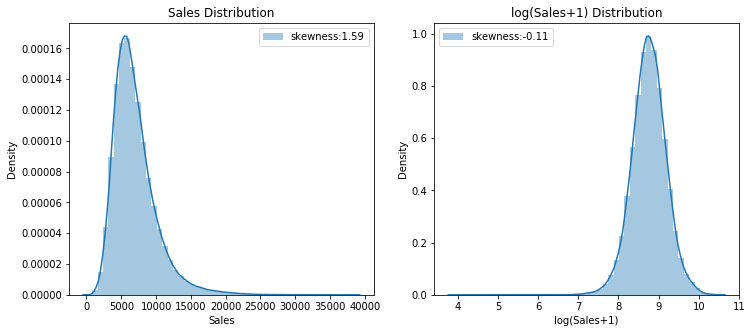

In [82]:
#绘制水平方向两个图
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
g1 = sns.distplot(train['Sales'],hist = True,label='skewness:{:.2f}'.format(train['Sales'].skew()),ax = ax1)
g1.legend()
g1.set(xlabel = 'Sales', ylabel = 'Density', title = 'Sales Distribution')
g2 = sns.distplot(np.log1p(train['Sales']),hist = True,label='skewness:{:.2f}'.format(np.log1p(train['Sales']).skew()),ax=ax2)
g2.legend()
g2.set(xlabel = 'log(Sales+1)',ylabel = 'Density', title = 'log(Sales+1) Distribution')
plt.show()

In [83]:
#数据划分与处理
def process(data, isTest = False):
    # 标签编码
    mappings = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
    data.StoreType.replace(mappings, inplace=True)
    data.Assortment.replace(mappings, inplace=True)
    data.StateHoliday.replace(mappings, inplace=True)
    
    # 提取特征  
    data['Month'] = data.Date.dt.month
    data['Year'] = data.Date.dt.year
    data['Day'] = data.Date.dt.day
    data['WeekOfYear'] = data.Date.dt.weekofyear
    
    # 以月份计算竞争者营业时间
    data['CompetitionOpen'] = 12 * (data.Year - data.CompetitionOpenSinceYear) + \
        (data.Month - data.CompetitionOpenSinceMonth)
    data['CompetitionOpen'] = data['CompetitionOpen'].apply(lambda x: x if x > 0 else 0)
    
    # 计算二次促销开始时间
    data['PromoOpen'] = 12 * (data.Year - data.Promo2SinceYear) + \
        (data.WeekOfYear - data.Promo2SinceWeek) / 4.0
    data['PromoOpen'] = data['PromoOpen'].apply(lambda x: x if x > 0 else 0)
                                                 
    # 判断间隔是否是促销月
    monthmap = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', \
             7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    data['month_str'] = data.Month.map(monthmap)

    def check(row):
        if isinstance(row['PromoInterval'],str) and row['month_str'] in row['PromoInterval']:
            return 1
        else:
            return 0
        
    data['IsPromoMonth'] =  data.apply(lambda row: check(row),axis=1)    
    
    # 选择需要的特征
    selected_features = ['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday',
       'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'Year', 'Month', 'Day',
       'WeekOfYear', 'CompetitionOpen', 'PromoOpen', 'IsPromoMonth']  
    if not isTest:
        features.append('Sales')
        
    data = data[selected_features]
    return data
    
    train = process(train)
    valid = process(valid)
    train_total = process(train_total)
    x_test = process(test,isTest = True) 

In [84]:
#排序
valid.sort_index(inplace = True)
train.sort_index(inplace = True)
train_total.sort_index(inplace = True)

In [85]:
#划分数据集
x_train, y_train = train.drop(columns = ['Sales']), np.log1p(train['Sales'])
x_valid, y_valid = valid.drop(columns = ['Sales']), np.log1p(valid['Sales'])
x_train_total, y_train_total = train_total.drop(columns = ['Sales']), np.log1p(train_total['Sales'])

In [96]:
tmp_train=x_train.drop(columns=['Date'])
tmp_vaild=x_valid.drop(columns=['Date'])



In [97]:

clf = RandomForestRegressor(n_estimators = 20)
clf.fit(tmp_train, y_train)
# 验证
y_pred = clf.predict(tmp_vaild)
error = rmspe(np.expm1(y_valid), np.expm1(y_pred))
print('RMSPE: {:.4f}'.format(error))

ValueError: could not convert string to float: 'a'

In [98]:
feat_importances = pd.Series(clf.feature_importances_, index=x_train.columns)
feat_importances.nlargest(10).sort_values(ascending = True).plot(kind='barh')
plt.xlabel('importance')
plt.title('Feature Importance')

NotFittedError: This RandomForestRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

In [99]:
params = {"objective": "reg:linear", # 线性回归
          "booster" : "gbtree",   # 树模型
          "eta": 0.03,   # 学习率
          "max_depth": 10,    # 树最大深度
          "subsample": 0.9,    # 用于训练模型的子样本占整个样本集合的比例
          "colsample_bytree": 0.7,   # 在建立树时对特征采样的比例。缺省值为1
          "silent": 1,   # 取0时表示打印出运行时信息，取1时表示以默方式运行，不打印运行时信息。缺省值为0
          "seed": 10    }# 随机码
num_boost_round = 4000

dtrain = xgb.DMatrix(x_train, y_train)
dvalid = xgb.DMatrix(x_valid, y_valid)
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
# train the xgboost model
model = xgb.train(params, dtrain, num_boost_round, evals=watchlist, \
  early_stopping_rounds= 100, feval=rmspe_xg, verbose_eval=True)

ValueError: DataFrame.dtypes for data must be int, float or bool.
                Did not expect the data types in fields Date, StateHoliday, StoreType, Assortment, PromoInterval

In [ ]:
y_pred = model.predict(xgb.DMatrix(x_valid))
error = rmspe(np.expm1(y_valid), np.expm1(y_pred))
print('RMSPE: {:.4f}'.format(error))

In [ ]:
def correction():
    weights = np.arange(0.98, 1.02, 0.005)
    errors = []
    for w in weights:
        error = rmspe(np.expm1(y_valid), np.expm1(y_pred * w))
        errors.append(error)

    # 画曲线图
    plt.plot(weights, errors)
    plt.xlabel('weight')
    plt.ylabel('RMSPE')
    plt.title('RMSPE Curve')
    # print min error
    idx = errors.index(min(errors))
    print('Best weight is {}, RMSPE is {:.4f}'.format(weights[idx], min(errors)))
correction()

In [ ]:
dtrain = xgb.DMatrix(x_train_total, y_train_total)
dtest = xgb.DMatrix(x_test)
# specify parameters via map
params = {"objective": "reg:linear", # 线性回归
          "booster" : "gbtree",   # 树模型
          "eta": 0.03,   # 学习率
          "max_depth": 10,    # 树最大深度
          "subsample": 0.9,    # 用于训练模型的子样本占整个样本集合的比例
          "colsample_bytree": 0.7,   # 在建立树时对特征采样的比例。缺省值为1
          "silent": 1,   # 取0时表示打印出运行时信息，取1时表示以默认方式运行，不打印运行时信息。缺省值为0
          "seed": 10    }# 随机码
num_round = 3000
model = xgb.train(params, dtrain, num_round)
# 预测
preds = model.predict(dtest)

In [ ]:
result = pd.DataFrame({"Id": test["Id"],'Sales': np.expm1(preds*0.995)})
result.to_csv("submission_xgb.csv", index=False)

# 展示10个主要特征
fig, ax = plt.subplots(figsize=(8,8))
xgb.plot_importance(model, max_num_features= 10, height=0.5, ax=ax)
plt.show()